# Valuación de opciones con barrera

## 1. Recorderis de valuación usando simulación...

In [2]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [3]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [4]:
closes = get_adj_closes(['AAPL'], '2017-01-01')
closes_appl = closes.loc[:,'AAPL']
closes_appl

Date
2017-01-03    110.392
2017-01-04    110.269
2017-01-05    110.830
2017-01-06    112.065
2017-01-09    113.092
               ...   
2020-05-05    296.757
2020-05-06    299.818
2020-05-07    302.920
2020-05-08    310.130
2020-05-11    315.010
Name: AAPL, Length: 844, dtype: float64

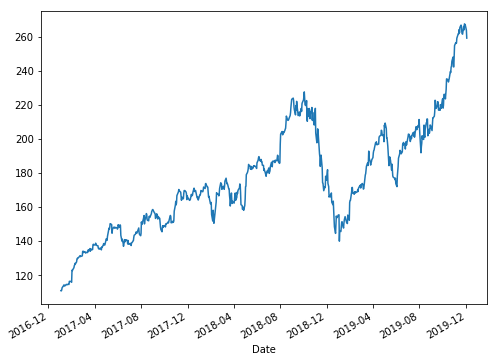

In [4]:
closes_appl.plot(figsize=(8,6));

In [5]:
closes_appl[-1]

315.010009765625

## Calculamos rendimientos

In [6]:
ret_appl = calc_daily_ret(closes_appl)

## Descargamos datos de opciones para poder valuarlos


Descargamos datos de opciones de Apple

In [14]:
pd.set_option('display.max_rows', 10)

appl = web.YahooOptions('AAPL')
appl_opt = appl.get_all_data().reset_index()
appl_opt.set_index('Expiry').sort_index()#.head(1000)

,Strike,Type,Symbol,...,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,
2020-05-15,345.0,call,AAPL200515C00345000,...,2020-05-12 13:11:34,2020-05-11 19:57:25,"{'contractSymbol': 'AAPL200515C00345000', 'str..."
2020-05-15,290.0,put,AAPL200515P00290000,...,2020-05-12 13:11:34,2020-05-11 19:59:58,"{'contractSymbol': 'AAPL200515P00290000', 'str..."
2020-05-15,290.0,call,AAPL200515C00290000,...,2020-05-12 13:11:34,2020-05-11 19:59:45,"{'contractSymbol': 'AAPL200515C00290000', 'str..."
2020-05-15,287.5,put,AAPL200515P00287500,...,2020-05-12 13:11:34,2020-05-11 19:59:56,"{'contractSymbol': 'AAPL200515P00287500', 'str..."
2020-05-15,287.5,call,AAPL200515C00287500,...,2020-05-12 13:11:34,2020-05-11 19:59:59,"{'contractSymbol': 'AAPL200515C00287500', 'str..."
...,...,...,...,...,...,...,...
2022-06-17,380.0,put,AAPL220617P00380000,...,2020-05-12 13:11:34,2020-04-21 16:53:16,"{'contractSymbol': 'AAPL220617P00380000', 'str..."
2022-06-17,195.0,put,AAPL220617P00195000,...,2020-05-12 13:11:34,2020-04-28 19:55:52,"{'contractSymbol': 'AAPL220617P00195000', 'str..."
2022-06-17,430.0,call,AAPL220617C00430000,...,2020-05-12 13:11:34,2020-05-08 17:51:45,"{'contractSymbol': 'AAPL220617C00430000', 'str..."


Opción que deseamos valuar

In [13]:
opt_deseada = appl_opt.loc[(appl_opt.Type=='call') & (appl_opt.Strike==320) & (appl_opt.Expiry=='2020-09-18')]
opt_deseada

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
1298,320.0,2020-09-18,call,...,2020-05-12 13:11:04,2020-05-11 19:59:53,"{'contractSymbol': 'AAPL200918C00320000', 'str..."


In [19]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            320
Expiry                                            2020-09-18 00:00:00
Type                                                             call
Symbol                                            AAPL200918C00320000
Last                                                               21
                                          ...                        
Underlying                                                       AAPL
Underlying_Price                                                  317
Quote_Time                                        2020-05-12 13:11:04
Last_Trade_Date                                   2020-05-11 19:59:53
JSON                {'contractSymbol': 'AAPL200918C00320000', 'str...
Name: 1298, Length: 19, dtype: object

Información de la opción

In [16]:
opt_valuar['JSON']

{'contractSymbol': 'AAPL200918C00320000',
 'strike': 320.0,
 'currency': 'USD',
 'lastPrice': 20.97,
 'change': 0.0,
 'percentChange': 0.0,
 'volume': 701,
 'openInterest': 4385,
 'bid': 0.0,
 'ask': 0.0,
 'contractSize': 'REGULAR',
 'expiration': 1600387200,
 'lastTradeDate': 1589227193,
 'impliedVolatility': 0.007822421875,
 'inTheMoney': False}

# Simulación de precios

### 1.1 Modelo normal de rendimientos

In [17]:
mu = ret_appl.mean()
sigma = ret_appl.std()
r = 0.0017/360
mu, sigma, r

(0.0012438478321112536, 0.019216702228571636, 4.722222222222222e-06)

### Simulación de precios

In [20]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_appl.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

### Valuación de la opción baśandonos en la función de pago correspondiente

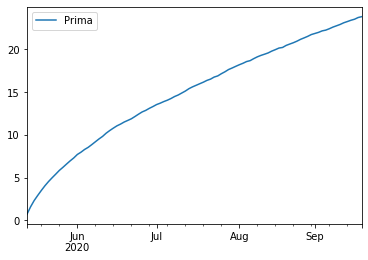

In [21]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call.plot();

In [22]:
call.iloc[-1]

Prima    23.826
Name: 2020-09-18 00:00:00, dtype: float64

### Intervarlos de confianza

In [23]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(22.653557937196126, 24.998367608175307)


In [24]:
opt_valuar['JSON']

{'contractSymbol': 'AAPL200918C00320000',
 'strike': 320.0,
 'currency': 'USD',
 'lastPrice': 20.97,
 'change': 0.0,
 'percentChange': 0.0,
 'volume': 701,
 'openInterest': 4385,
 'bid': 0.0,
 'ask': 0.0,
 'contractSize': 'REGULAR',
 'expiration': 1600387200,
 'lastTradeDate': 1589227193,
 'impliedVolatility': 0.007822421875,
 'inTheMoney': False}

### 1.2 Histograma de rendimientos

In [26]:
freq, values = np.histogram(ret_appl-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [27]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_appl.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret,index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

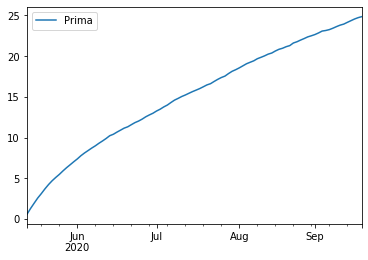

In [28]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [29]:
call_hist.iloc[-1]

Prima    24.838
Name: 2020-09-18 00:00:00, dtype: float64

In [30]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(23.64408026600345, 26.032680440832536)


Notemos que el valor real de la opción que estamos valuando se encuentra muy cerca del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.
El valor de la opción es:

In [31]:
opt_valuar['JSON']['lastPrice']

20.97

## 2. Aspectos teóricos

Para un activo con precio $S_t$, se considera una opción de la siguiente forma
\begin{equation}
    V_T=u(t)F_T
\end{equation}
para $0\leq t\leq T$. En este caso, $F_T=\max(S_T-K,0)$ para una opción tipo call o $F_T=\max(K-S_T,0)$ para una opción tipo put. La función $u(t)$ está definida en $0\leq t\leq T$, toma el valor de uno sí se cumple cierta condición y el valor de cero en otra caso. 

Por otra lado, para $B>0$ y $0<t<T$ se dice que $S_t$ ha superado la barrera $B$ sí $S_0<B$ y $S_t>B$ para algún tiempo $t$ en el periodo considerado. Similarmente, se dice que $S_t$ ha caído por debajo de la barrera $B$ sí $S_0>B$ y $S_t<B$ para algúnn tiempo $t$ en el periodo considerado.

Finalmente, para un enunciado $x$, se define la función indicadora $I(x)$ como $I(x)=1$ si $x$ se cumple e $I(x)=0$ en otro caso.

Se esta forma, pueden definirse las siguientes acciones

* Up-and-out: Sí $S_0<B$, entonces $u(t)=I(S_t<B)$.
* Down-and-out: Sí $S_0>B$, entonces $u(t)=I(S_t>B)$.
* Up-and-in: Sí $S_0<B$, entonces $u(t)=I(S_t>B)$.
* Down-and-in: Sí $S_0>B$, entonces $u(t)=I(S_t<B)$.

Así se se pueden definirse ocho nuevos tipos de opciones. 

* Up-and-out call: Sí $S_0<B$, $C_t^{uo}=\max\{S_T-K,0\}I(S_t<B)$
* Down-and-out call: Sí $S_0>B$, $C_t^{do}=\max\{S_T-K,0\}I(S_t>B)$
* Up-and-in call: Sí $S_0<B$, $C_t^{ui}=\max\{S_T-K,0\}I(S_t>B)$
* Down-and-in call: Sí $S_0>B$, $C_t^{di}=\max\{S_T-K,0\}I(S_t<B)$
* Up-and-out put: Sí $S_0<B$, $P_t^{uo}=\max\{K-S_T,0\}I(S_t<B)$
* Down-and-out put: Sí $S_0>B$, $P_t^{do}=\max\{K-S_T,0\}I(S_t>B)$
* Up-and-in put: Sí $S_0<B$, $P_t^{ui}=\max\{K-S_T,0\}I(S_t>B)$
* Down-and-in put: Sí $S_0>B$, $P_t^{di}=\max\{K-S_T,0\}I(S_t<B)$


A las del tipo *up-and-out* y *down-and-out* se les conoce como opciones *knock-out*. De la misma forma, a las del tipo *up-and-in* y *down-and-in* se les conoce como opciones *knock-in*.

Note que estas son **opciones dependientes de la trayectoria del precio**, dado que $u(t)$ depende de $S_t$.

> Son opciones para aquellos inversores que tengan unas expectativas muy claras sobre la dirección, ascendente o descendente, del precio del subyacente, y apuesten fuertemente por ello. 

## 2.1 Knock-out
Si el precio spot toca la barrera antes del vencimiento, las opciones se desactivan.

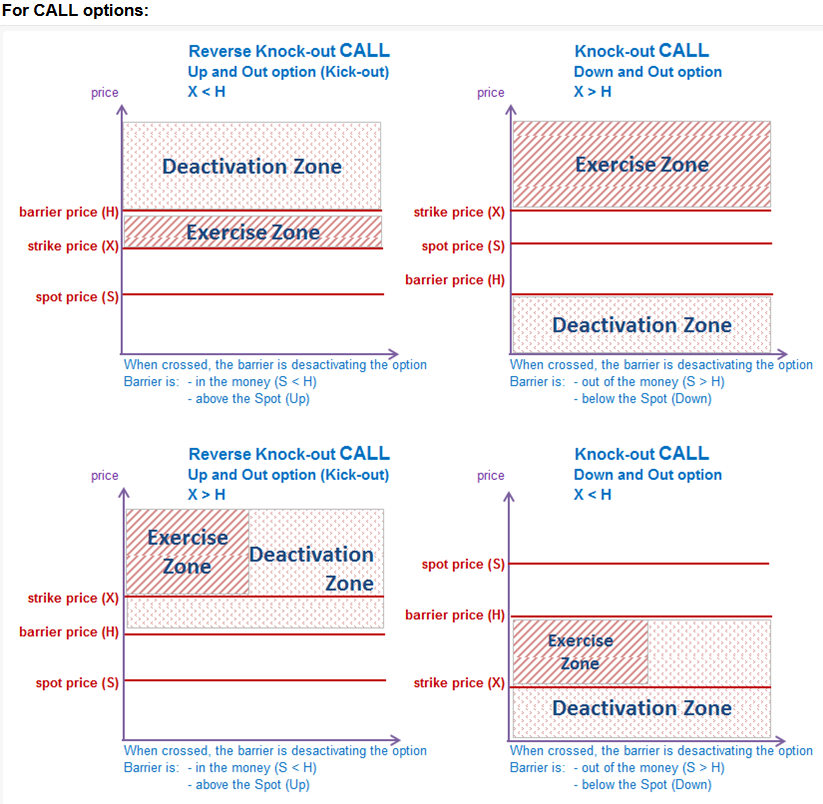

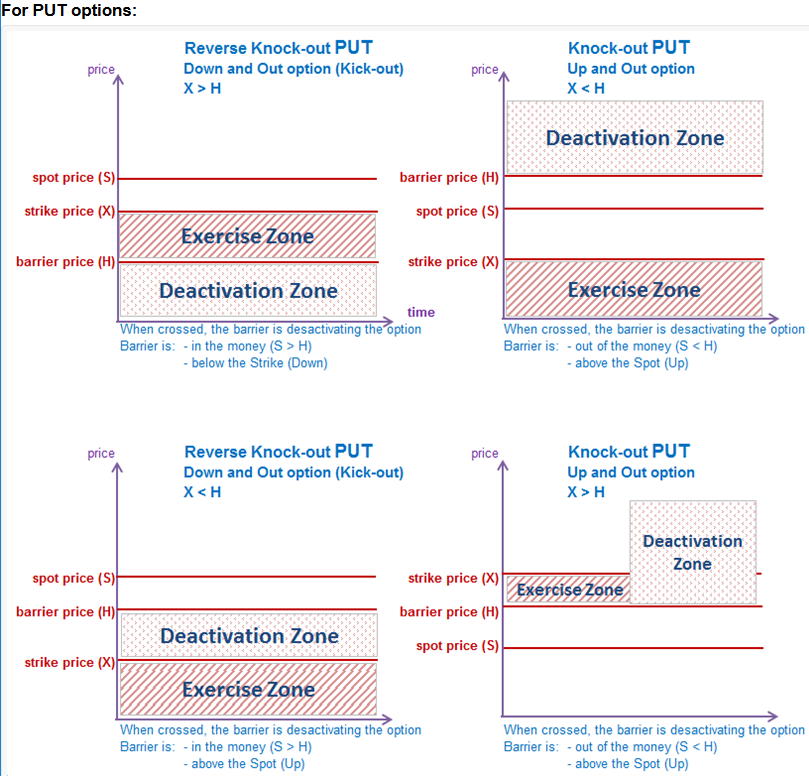

## 2.2 Knock-in

Una vez que el precio spot toca la barrera antes de su vencimiento, las opciones se activan.

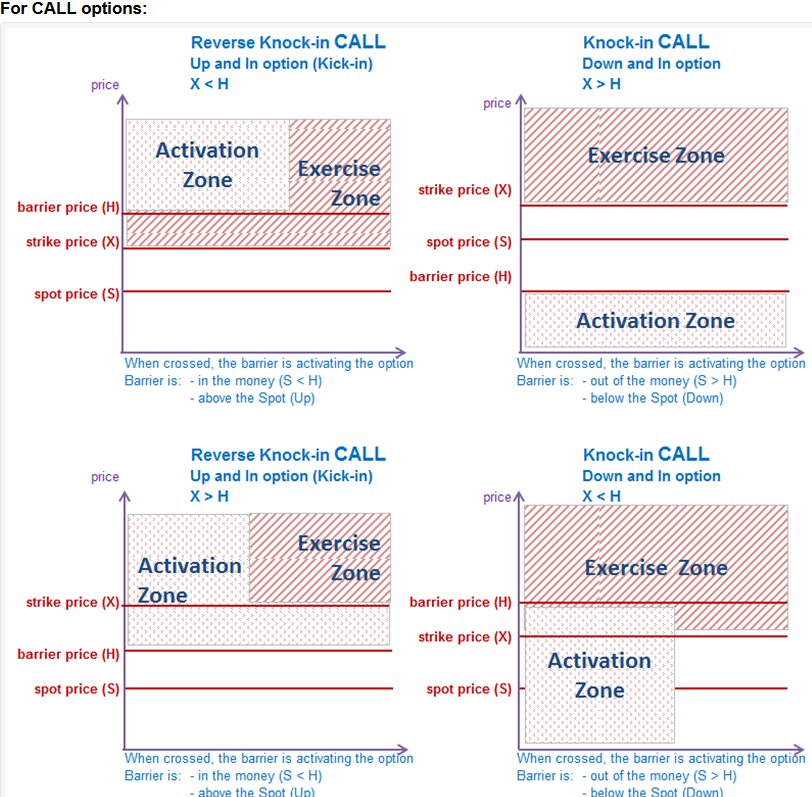

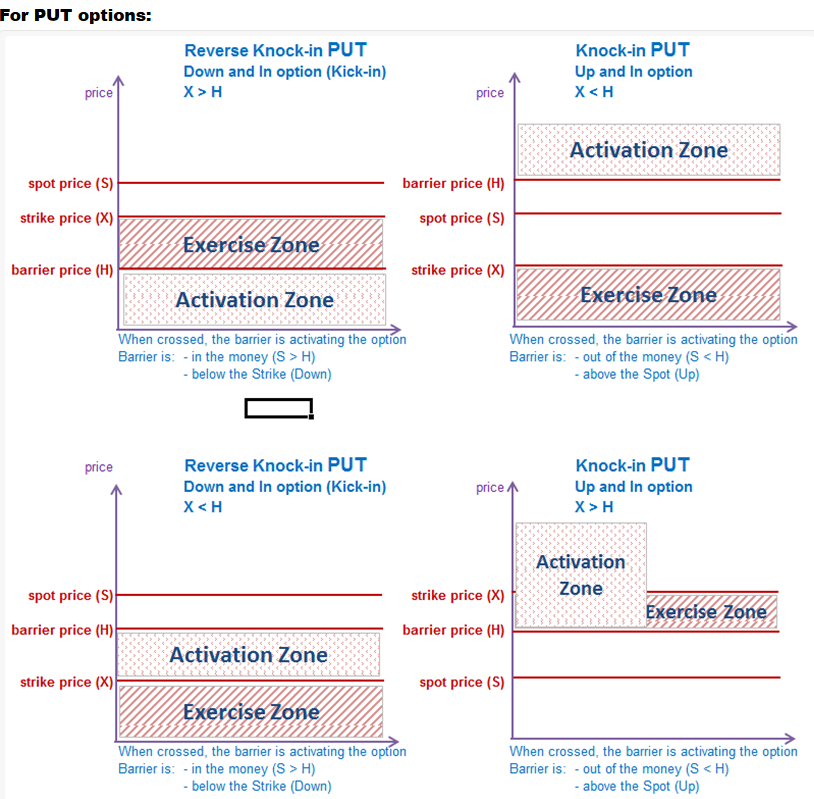

## 3. Valuación de una opción up and in

### 3.1 Modelo normal de rendimientos

In [32]:
mu = ret_appl.mean()
sigma = ret_appl.std()
r = 0.0017/360
mu, sigma, r

(0.0012438478321112536, 0.019216702228571636, 4.722222222222222e-06)

In [35]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_appl.iloc[-1]

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
S0

315.010009765625

Hasta la simulación, todo normal... falta crear la función indicadora

In [37]:
pd.set_option('display.max_columns', 15)

B = 350    # Precio barrera
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
# Función de activación (knock-in)
# Si en algún momento el precio toca la barrera la opción se activa
I = (sim_closes>barrier).cumsum()>0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2020-05-12,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
2020-05-13,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
2020-05-14,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
2020-05-15,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
2020-05-18,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-14,True,True,True,False,False,False,True,...,False,True,False,True,False,False,True
2020-09-15,True,True,True,False,False,False,True,...,False,True,False,True,False,False,True
2020-09-16,True,True,True,False,False,False,True,...,False,True,False,True,False,False,True
2020-09-17,True,True,True,False,False,False,True,...,False,True,False,True,False,False,True


In [46]:
# Función de desactivación (knock-out)
# Si en algún momento el precio toca la barrera la opción se desactiva
barrier = 300
I = (sim_closes>barrier).cumprod()>0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2020-05-12,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2020-05-13,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2020-05-14,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True
2020-05-15,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True
2020-05-18,True,True,True,False,False,True,True,...,True,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-14,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False
2020-09-15,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False
2020-09-16,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False
2020-09-17,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False


## Valuación opción call up-and-in

In [44]:
K = opt_valuar.Strike
S0 = opt_valuar.Underlying_Price
K, S0

(320.0, 317.3)

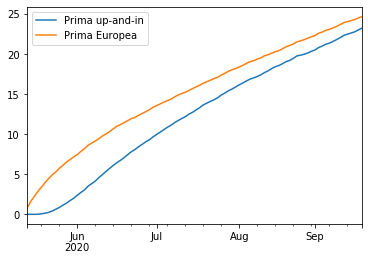

In [52]:
B = 360
I = (sim_closes > B).cumsum() > 0
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros((ndays,nscen))).T.mean()},index=dates)
callui = pd.DataFrame({'Prima up-and-in':np.exp(-r*ndays)*(I*np.fmax(sim_closes-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = callui.plot();
call.plot(ax=ax);

In [53]:
call.iloc[-1]

Prima Europea    24.674
Name: 2020-09-18 00:00:00, dtype: float64

In [54]:
callui.iloc[-1]

Prima up-and-in    23.231
Name: 2020-09-18 00:00:00, dtype: float64

# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price y una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez and modify by Oscar David Jaramillo Z.
</footer>